In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [15]:
# constants
V_0 = -5.0
R = 6.0
M = 50

x = np.linspace(-R, R, M+1)
delta = x[1] - x[0]

In [16]:
def V(x):
    return V_0 * np.exp(-x**2)

# functions in S_{3,2}
def phi(k, x_):
    return (-1/delta**2 * (x_-x[k])**2 + 1) \
            * np.heaviside(x_ - x[k] + delta, 0) \
            * np.heaviside(-x_ + x[k] + delta, 0)

def psi(k, x_):
    return (-1/delta**2 * (x_-x[k])**3 + (x_-x[k]))\
            * np.heaviside(x_ - x[k] + delta, 0)\
            * np.heaviside(-x_ + x[k] + delta, 0)

# second derivatives of these functions
def phi_xx(k, x_):
    return -2/delta**2\
            * np.heaviside(x_ - x[k] + delta, 0) \
            * np.heaviside(-x_ + x[k] + delta, 0)

def psi_xx(k, x_):
    return -6/delta**2 * (x_-x[k]) \
            * np.heaviside(x_ - x[k] + delta, 0) \
            * np.heaviside(-x_ + x[k] + delta, 0)


# functions that form something like basis in S_{3,2}
def S(l, x_):
    if l == 0 or l == 2*M:
        return psi(l//2, x_)
    elif l % 2 == 1:
        return psi((l+1)//2, x_)
    else:
        return phi(l//2, x_)

# and their second derivatives
def S_xx(l, x_):
    if l == 0 or l == 2*M:
        return psi_xx(l//2, x_)
    elif l % 2 == 1:
        return psi_xx((l+1)//2, x_)
    else:
        return phi_xx(l//2, x_)

In [17]:
# collocation points
x_c = np.zeros(2*M)

x_c[::2] = x[:-1] + delta/2 * (1 - 1/np.sqrt(3))
x_c[1::2] = x[:-1] + delta/2 * (1 + 1/np.sqrt(3))

In [24]:
T = np.zeros((2*M, 2*M))
P = np.zeros((2*M, 2*M))
B = np.zeros((2*M, 2*M))

for l in range(2*M):
    for t in [l-2, l-1, l, l+1, l+2]:
        if t < 2*M and t >=0:
            T[l,t] = -S_xx(l, x_c[t])
            P[l,t] = V(x_c[t]) * S(l, x_c[t])
            B[l,t] = S(l, x_c[t]) 

R = lambda z : scipy.linalg.inv(P - z * B)
L = lambda z : - R(z) @ T

In [25]:
def arnoldi_iteration(A, b, n: int):
    """Computes a basis of the (n + 1)-Krylov subspace of A: the space
    spanned by {b, Ab, ..., A^n b}.

    Arguments
      A: m × m array
      b: initial vector (length m)
      n: dimension of Krylov subspace, must be >= 1
    
    Returns
      Q: m x (n + 1) array, the columns are an orthonormal basis of the
        Krylov subspace.
      h: (n + 1) x n array, A on basis Q. It is upper Hessenberg.  
    """
    eps = 1e-12
    h = np.zeros((n+1,n))
    Q = np.zeros((A.shape[0],n+1))
     # Normalize the input vector
    Q[:,0] =b/np.linalg.norm(b,2)   # Use it as the first Krylov vector
    for k in range(1,n+1):
        v = np.dot(A,Q[:,k-1])  # Generate a new candidate vector
        for j in range(k):  # Subtract the projections on previous vectors
            h[j,k-1] = np.dot(Q[:,j].T, v)
            v = v - h[j,k-1] * Q[:,j]
        h[k,k-1] = np.linalg.norm(v,2)
        if h[k,k-1] > eps:  # Add the produced vector to the list, unless
            Q[:,k] = v/h[k,k-1]
        else:  # If that happens, stop iterating.
            return Q, h
    return Q, h

In [26]:
n = 100 # how many branches of lambda with wich we want to deal 

z = np.linspace(V_0,0.0,100)
lambda_ = np.full((n, len(z)), np.nan)

for i in range(len(z)):
    
#     if i % 10 == 0:
    print(i)
        
    b = np.random.rand(2*M)
    Q, h = arnoldi_iteration(L(z[i]), b, n)
    
    lambda_[:,i] = np.real(scipy.linalg.eigvals(h[:-1]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


0 -4.49619294820918
3 -1.4095367163387544
4 -0.8585586631340377
7 -3.712370501823696
8 -4.2150035793703955


Text(0.5, 1.0, '$V_0 = -5.00$')

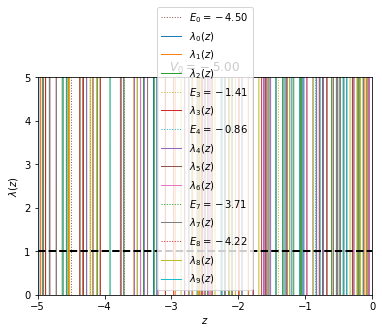

In [27]:
for i in range(10):
    lambda_cs = scipy.interpolate.CubicSpline(z, lambda_[i])
    
    if (lambda_cs(V_0)<1) and (lambda_cs(0.0)>1):
        sol = scipy.optimize.root_scalar(lambda x: lambda_cs(x) - 1.0, bracket=[V_0, 0.0], method='brentq')
        print(i, sol.root)
        plt.axvline(x=sol.root, linewidth=1, color=f'C{i+5}', linestyle=':', label=fr'$E_{i} = {sol.root:>0.2f}$')
    
    plt.plot(z, lambda_[i], linewidth=1, label=fr'$\lambda_{i}(z)$')
    
    
plt.axhline(y=1, linestyle='--', color='black', linewidth=2)


plt.legend()
plt.xlim(V_0,0.0)
plt.ylim(0.0,5)
plt.xlabel(r'$z$')
plt.ylabel(r'$\lambda(z)$')
plt.title(fr'$V_0 = {V_0:>0.2f}$')